In [ ]:
ffrom google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DELETE STAMPS
find "stamp"


#### Dataset:

Feature dataset is public on Dacheng Xiu's website. File name is \'datashare.csv'. file found in directory. This file is a 3.6 GB file and does not open on excel.
I use Pandas library to preprocess the data.
The dependent variables (1-month holding period returns) are extracted from CRSP database. I extract monthly holding period returns from from 12-1925 to 12-2022 , as I could not access any more recent return. (NB : I am using crsp_a_stock package on WRDS).
Macro dataset is public on Amit Goyal's webiste. File name is \'PredictorData2022.csv' file is in directory.

I process and clean the data, then provide a summary of the dataset by analyse by analysising its empirics. I finally apply statistical methods on the data.



I comment out sections of code when their output occupies excessive screen space.

#### Data Analysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import time

In [ ]:
file_return = '/content/drive/MyDrive/charbel/returns_only.csv'
file_feature = '/content/drive/MyDrive/charbel/datashare.csv'

data_return= pd.read_csv(file_return)
data_feature =  pd.read_csv(file_feature)

In [ ]:
#print("List of variables \n", data_feature.columns.tolist()  ) # list of all vars in this file  - factors file
#print("\n head \n",data_feature.head())  # first few rows
print("\n Count Null \n" ,data_feature.isnull().sum())  # Shows the number of null values in each column


 Count Null 
 permno             0
DATE               0
mvel1           3070
beta          400564
betasq        400564
               ...  
retvol          3479
std_dolvol    316358
std_turn      305807
zerotrade     309813
sic2          300359
Length: 97, dtype: int64


Those correspond to the (97-DATE-pernmo-sic2) 94 characteristics described in the table in appendix . Pernmo is each stock's identifier in CRSP's database & and sic2 are Standard Industrial Classification (SIC) codes.
RET refers to the Holding Period Return
Now for the returns file

In [ ]:
print("List of variables \n", data_return.columns.tolist()  ) # list of all vars in this file  - factors file
print("\n Count Null \n" ,data_return.isnull().sum())  # Shows the number of null values in each column

List of variables 
 ['PERMNO', 'date', 'COMNAM', 'PERMCO', 'PRC', 'RET']

 Count Null 
 PERMNO         0
date           0
COMNAM     35001
PERMCO         0
PRC       150689
RET        85298
dtype: int64


I change variable names in order to merge both dataframes later and for clarity.

In [ ]:
data_return = data_return.rename(columns={'PERMNO': 'permno'})
data_return = data_return.rename(columns={'date': 'DATE'})

In [ ]:
print(len(data_return), len(data_feature))

4927531 4117300



### Merging returns and their associated features

In [ ]:
merged_data = pd.merge(data_feature, data_return, how='inner', on=['permno', 'DATE'])

In [ ]:
print("\n Count Null \n" ,merged_data.isnull().sum())  # Shows the number of null values in each column


 Count Null 
 permno         0
DATE           0
mvel1       3070
beta      400564
betasq    400564
           ...  
sic2      300359
COMNAM         0
PERMCO         0
PRC        20481
RET        20468
Length: 101, dtype: int64


I have merged both (inner merge wrt pernmo and date) in the "merged_data" dataframe




Use different dates

In [ ]:
#start_date, end_date = 19570101, 20161231
start_date, end_date = 20010101, 20201231

In [ ]:
merged_data = merged_data[(merged_data['DATE']>=start_date)&(merged_data['DATE']<=end_date)].reset_index(drop=True)
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'],format='%Y%m%d')+pd.offsets.MonthEnd(0) #change time format

In [ ]:
#print("List of variables for merged and constrained \n", merged_data.columns.tolist()  ) # list of all vars in this file  - factors file
#print("\n head \n",merged_data.head())  # first few rows
print("\n Count Null \n" ,merged_data.isnull().sum())  # Shows the number of null values in each column
print("number of observations" , len(merged_data))


 Count Null 
 permno        0
DATE          0
mvel1       255
beta      98296
betasq    98296
          ...  
sic2      22491
COMNAM        0
PERMCO        0
PRC        7810
RET        7799
Length: 101, dtype: int64
number of observations 1487672


I end up with 1,487,672 observations

I define a list of firms' characteristics as defined in paper. I exclude company name , database IDs (permno & permnco ) , date, returns and industry code (sic) to get the list of characteristics

In [ ]:
characteristics = list(set(merged_data.columns).difference({'DATE','permno','COMNAM','sic2','PERMCO','PRC','RET'}))

In [ ]:
print(str(characteristics) + " are the firms' characteristics. \nThere are " + str(len(characteristics)) + " characteristics.")

['stdcf', 'divo', 'pchgm_pchsale', 'chpmia', 'orgcap', 'pchsaleinv', 'maxret', 'beta', 'roavol', 'cfp', 'grcapx', 'cfp_ia', 'tang', 'pchcapx_ia', 'ep', 'invest', 'chinv', 'securedind', 'agr', 'age', 'cashdebt', 'divi', 'lgr', 'pchsale_pchinvt', 'chatoia', 'chcsho', 'egr', 'roic', 'pricedelay', 'aeavol', 'pchquick', 'operprof', 'chtx', 'dolvol', 'rd_mve', 'pchdepr', 'pchsale_pchxsga', 'mom12m', 'mve_ia', 'std_turn', 'herf', 'chempia', 'sp', 'gma', 'grltnoa', 'currat', 'rsup', 'ms', 'absacc', 'bm', 'dy', 'stdacc', 'turn', 'tb', 'secured', 'cinvest', 'cashpr', 'mvel1', 'ill', 'chmom', 'sgr', 'mom6m', 'pchcurrat', 'idiovol', 'convind', 'roeq', 'cash', 'mom1m', 'lev', 'salerec', 'depr', 'sin', 'saleinv', 'ps', 'nincr', 'quick', 'zerotrade', 'pctacc', 'ear', 'hire', 'salecash', 'indmom', 'acc', 'realestate', 'rd_sale', 'pchsale_pchrect', 'rd', 'retvol', 'baspread', 'roaq', 'std_dolvol', 'bm_ia', 'mom36m', 'betasq'] are the firms' characteristics. 
There are 94 characteristics.


## MISSING DATA
I drop observations for which I do not have the monthly holding period return
and Replace the missing features with median of characteristic's value for each stock


In [ ]:
merged_data.isnull().sum()

permno        0
DATE          0
mvel1       255
beta      98296
betasq    98296
          ...  
sic2      22491
COMNAM        0
PERMCO        0
PRC        7810
RET        7799
Length: 101, dtype: int64

There are missing returns in the data

In [ ]:
#merged_data[merged_data['RET'].isnull()].tail(20)[['permno', 'DATE']] #last 20 missing returns
#we see that the N/A observations are not specific to some particular time frame
#merged_data[merged_data['RET'].isnull()].head(20)[['permno', 'DATE']] #First 20 missing returns

##### Drop obsevations for which returns are not available
###### Now : the merged_data has become "merged_data_updt",after dropping the missing return

In [ ]:
merged_data_updt = merged_data.dropna(subset=['RET']).reset_index(drop=True)

In [ ]:
print(merged_data_updt.isnull().sum())

permno        0
DATE          0
mvel1       244
beta      98118
betasq    98118
          ...  
sic2      21717
COMNAM        0
PERMCO        0
PRC          11
RET           0
Length: 101, dtype: int64


More cleaning
*   In the returns columns (RET)  there are also some defective values ( characters instead of numerical values)
*   I spot them, then update the merged_data_updt dataframe accordingly



In [ ]:
non_convertible_indices = merged_data_updt.loc[pd.to_numeric(merged_data_updt['RET'], errors='coerce').isna()].index
non_convertible_elements = merged_data_updt.loc[pd.to_numeric(merged_data_updt['RET'], errors='coerce').isna(), 'RET']
print(non_convertible_indices)
print(non_convertible_elements.head(3))

Int64Index([   8499,  415015,  639821,  699752,  795249,  926856, 1339620,
            1377438, 1383112, 1432729, 1444702, 1454346],
           dtype='int64')
8499      B
415015    B
639821    B
Name: RET, dtype: object


In [ ]:
#stamp
print("the number of defective returns", len(non_convertible_indices))

the number of defective returns 12


In [ ]:
merged_data_updt = merged_data_updt.drop(index=non_convertible_indices).reset_index(drop=True)

In [ ]:
#stamp
print("the number of observations", len(merged_data_updt))

the number of observations 1479861


## Sort out top and bottom firms. I create two datasets : One for the 10000 biggest firms and another for the 10000 smallest firms (cross-sectionally)
merged_data_top : For each date, I sort the top 1000 firms ( according to their size : mvel1) descendingly. merged_data_bottom : same but top 1000 smallest firms .

In [ ]:
merged_data_top = merged_data_updt.sort_values('mvel1',ascending=False).groupby('DATE').head(1000).reset_index(drop=True)
merged_data_bottom = merged_data_updt.sort_values('mvel1',ascending=False).groupby('DATE').tail(1000).reset_index(drop=True)

In [ ]:
print(merged_data_top.isnull().sum())
#print(merged_data_bottom.isnull().sum())
#print(len(merged_data_bottom) , len(merged_data_top))
#rint(len(merged_data_bottom.columns))

permno       0
DATE         0
mvel1        0
beta      5453
betasq    5453
          ... 
sic2      1540
COMNAM       0
PERMCO       0
PRC          0
RET          0
Length: 101, dtype: int64


I end up with  ~1,5 Mln observations for the whole panel and 240,000 observations for top and bottom panels ( That is because for each of the 240 time frames, I pick the 1000 biggest and smallest firms)


###### I now want to replace the missing values by the cross sectional median value at each month. For this, I first group by date then for each characteristic (i), I use the function defined by lambda x:x.fillna(x.median()). lambda is a generic way to define a function ( w/out passing by def()) to transform each characteristic to an updated one whereby N/A values are filled by the median in a given date group.

In [ ]:
for i in characteristics:
     merged_data_updt[i] = merged_data_updt.groupby('DATE')[i].transform(lambda x: x.fillna(x.median()))

In [ ]:
columns_with_missing_values = merged_data_updt.columns[merged_data_updt.isnull().any()]
print(columns_with_missing_values)

Index(['sic2'], dtype='object')


In [ ]:
temp_merged_updt_2001 = merged_data_updt   # create a temp var for comparison - later in the code (nxt 2 lines)

##### For the 2001-2020 time windows, this is sufficient, but, it might be the case that all values of characteristics in a certain group might be null,replacing NA by the median would be innefective. To be on the safe side, I replace the remaining N/A by 0.   

##### Because the previous step is dependent on the initial time frame, then, it may or may not be needed. I verify this here:

In [ ]:
for i in characteristics:
     merged_data_updt[i] = merged_data_updt[i].fillna(0)

In [ ]:
# Checking
are_equal = temp_merged_updt_2001.equals(merged_data_updt)
print("Are the DataFrames equal?", are_equal,". if true, we're good to go. nothing has changed ( NOTE: This result changes from an initial time window to another)")

Are the DataFrames equal? True . if true, we're good to go. nothing has changed ( NOTE: This result changes from an initial time window to another)


I do the same for bottom and top dataframes
Now add to the name of top and bottom dataframes :
#### "_updt"

In [ ]:
def fill_missing(data, characteristics):
    for i in characteristics:
         data[i] = data.groupby('DATE')[i].transform(lambda x: x.fillna(x.median()))
    for i in characteristics:
         data[i] = data[i].fillna(0)
    return data

In [ ]:
merged_data_top_updt = fill_missing(merged_data_top, characteristics)
merged_data_bottom_updt = fill_missing(merged_data_bottom, characteristics)

In [ ]:
print("missing data in top:",merged_data_top_updt.columns[merged_data_top_updt.isnull().any()]) #checking for missing vars
print("missing data in bottom",merged_data_bottom_updt.columns[merged_data_bottom_updt.isnull().any()] )

missing data in top: Index(['sic2'], dtype='object')
missing data in bottom Index(['sic2'], dtype='object')


 No relevant missing variable. We are good to go. I check if there are still 1000 stocks per month.

In [ ]:
#[(merged_data_top_updt.groupby('DATE')['permno'].nunique() != 1000).any()]
#[(merged_data_bottom_updt.groupby('DATE')['permno'].nunique() != 1000).any()] # yes, we are good to go

##### Now that I got rid of observations with missing dependent variables ; and solved the problem of missing value.
I create dummy vars for the SIC variable. SIC are the standard industial classification codes: The 2 first digits defining it represent an industry section. I want to represent them as dummy variables

I use get_dummies() from pandas library. and define a function that first on gets dummies on for the sic2 column and fills missing values by 619619 in order to drop them later; Now this function - in its standard version creates a col for each diff variable and gives it the same name as the variable - this function also permits adding a prefix (written prefix_), I add sic; then at the end drop the NA sic

I will also drop irrelevant variables in the process

In [ ]:
def create_sic_dummies(df):
    sic_dummies = pd.get_dummies(df['sic2'].fillna("619619").astype(int),prefix='sic').drop('sic_619619',axis=1)
    df_dummy = pd.concat([df,sic_dummies],axis=1) # merge
    df_dummy.drop(['PERMCO','PRC','sic2'],inplace=True,axis=1) #drop sic2 , we do not need it anymore. And  drop irrelevant columns. Keep Permno, Date and Company name
    return df_dummy

In [ ]:
merged_data_updt_dummy = create_sic_dummies(merged_data_updt)

In [ ]:
#print("List of variables W/ DUMMY \n", merged_data_updt_dummy.columns.tolist()  )
#print("\n head \n",merged_data_updt_dummy.head())  # first few rows
#print("\n tail \n",merged_data_updt_dummy.tail())  # last few rows
#print(merged_data_updt_dummy.isnull().any().sum()) #should print false
print( "\nthe number of dummy variables" ,len((merged_data_updt_dummy).columns) - len((merged_data_updt).columns) + 3 )
#print(len((merged_data_updt_dummy).columns))


the number of dummy variables 73


The merged data is now called: merged_data_updt_dummy
Given the chosen time period I have 73 dummies representing the different industry sectors


No more missing values in firms' characteristics, and observations with n/a returns are dropped

We're done with merging returns to features and cleaning the merged data

STAMP : IN THE TXT BELOW ; YOU NEED TO UPDATE THE "NUMBER OF DEFECTIVE RETURNS"

#### To resume :
We are using (Given the 2001-2020 time frame) : 1,479,873 - (defective returns) observations from the beginning of 2001 to the end of 2020.
for 14,614 firms
and 94 characteristics
73 sector dummies
and the dataframe contains 171 columns ( Note: In the cleaning process I got rid of unuseful cols


I do the same thing with top and bottom dataframes


In [ ]:
merged_data_top_updt_dummy = create_sic_dummies(merged_data_top_updt)
merged_data_bottom_updt_dummy = create_sic_dummies(merged_data_bottom_updt)

In [ ]:
#[(merged_data_top_updt_dummy.groupby('DATE')['permno'].nunique() != 1000).any()]
#[(merged_data_bottom_updt.groupby('DATE')['permno'].nunique() != 1000).any()]

Note we get for top 1000 :

In [ ]:
#print(merged_data_top_updt_dummy.head())
#print(merged_data_bottom_updt_dummy.head())
#print(len((merged_data_top_updt_dummy.columns)))
print( "\nthe number of dummy variables for top dataframe is " ,len((merged_data_top_updt_dummy).columns) - len((merged_data_top_updt).columns) + 3 )
print( "\nthe number of dummy variables for bottom dataframe is " ,len((merged_data_bottom_updt_dummy).columns) - len((merged_data_top_updt).columns) + 3 )
#print("\n\n\n\n\n\n\n\n")
#print(merged_data_top_updt_dummy[merged_data_top_updt_dummy['DATE']<(np.datetime64('2009-01-31'))].tail())


the number of dummy variables for top dataframe is  66

the number of dummy variables for bottom dataframe is  71


# **Note**
I spot an error in the permnos

In [ ]:
#print(merged_data_updt_dummy.columns.tolist())
print("number of different company names" , merged_data_updt_dummy['COMNAM'].nunique() , "Number of different permnos", merged_data_updt_dummy['permno'].nunique() )

number of different company names 17851 Number of different permnos 15614


This suggests that the permnos refer to more than one company name.
I solve this issue  

In [ ]:
# Determining the issue
#print(merged_data_updt_dummy.head())
result_df = merged_data_updt_dummy.groupby('permno')['COMNAM'].nunique(dropna=True).reset_index(name='unique_names_count')
result_df = result_df[result_df['unique_names_count'] > 1]
print(result_df[['permno', 'unique_names_count']])

       permno  unique_names_count
0       10001                   3
1       10002                   2
2       10012                   2
7       10028                   3
10      10037                   2
...       ...                 ...
15597   93416                   2
15606   93429                   2
15608   93431                   2
15610   93433                   2
15613   93436                   2

[3086 rows x 2 columns]


Permnos are bad identifiers as they refer to more than 1 company name sometimes.
For example for 10001 we can see the list of company names

In [ ]:
merged_data_updt_dummy.loc[merged_data_updt_dummy['permno'] == 10001 , 'COMNAM'].unique()  #for example here are 3 COMNAM for permno 10001
#merged_data_updt_dummy.loc[merged_data_updt_dummy['permno'] == 10016 , 'COMNAM'].unique()  # Just checking, As expected , I got just 1 permno for 10016

array(['ENERGY WEST INC', 'ENERGY INC', 'GAS NATURAL INC'], dtype=object)

In [ ]:
#checking if there are in the same time period, two permnos .
has_duplicates = merged_data_updt_dummy.groupby('DATE')['permno'].transform(lambda x: x.duplicated(keep=False))
print(has_duplicates.any()) #False. I am good to go .

False


I want for every company name an id, then delete the permno and replace it by the ids

In [ ]:
print(merged_data_updt_dummy['COMNAM'].isnull().sum())  #checking if there are missing column names; should get 0
merged_data_updt_dummy['ID'] = merged_data_updt_dummy.groupby('COMNAM').ngroup() # create id for each new name

0


In [ ]:
#uncomment to check
#print(merged_data_updt_dummy.head())
#print(merged_data_updt_dummy[merged_data_updt_dummy['ID'] == 347]['COMNAM'].head(1))  #CHANGE ID number to see the observations (and corresponding permno)
#print("The number of firms/IDs is", merged_data_updt_dummy["ID"].nunique())

I can now drop the permno. And use the ID.
I will then rename the "ID" to "permno". To keep the code simple.
### merged_data_mod

In [ ]:
merged_data_mod = merged_data_updt_dummy.drop('permno',axis=1)

Change 'ID' to 'permno'

In [ ]:
#print(merged_data_mod.head())
merged_data_mod = merged_data_mod.rename(columns={'ID':'permno'})

In [ ]:
#print(merged_data_mod.head(3))

I am good to go . I now have identifiers for each firm .
Before proceeding:
I also replace permnos for top and bottom firms.
To do this:

*   I first re-organize the top panel. Sort them by date; then by size whithin each date : "_org"
*   Then, I check if the ID issue is present (should be if data is correct), and solve it.



In [ ]:
#print(merged_data_top_updt_dummy.head())
merged_top_org = merged_data_top_updt_dummy.sort_values(by=['DATE', 'mvel1'], ascending=[True, True]).reset_index(drop=True)
merged_bottom_org = merged_data_bottom_updt_dummy.sort_values(by=['DATE', 'mvel1'], ascending=[True, True]).reset_index(drop=True)

In [ ]:
#print(merged_top_org.head(3))
#print(merged_bottom_org.head())
#check for id problem
print("For the top panel number of different company names" , merged_top_org['COMNAM'].nunique() , "Number of different permnos", merged_top_org['permno'].nunique() )
print("\nNow for the bottom panel number of different company names" , merged_bottom_org['COMNAM'].nunique() , "Number of different permnos", merged_bottom_org['permno'].nunique() )



I have 3,362 firms for the top panel and 6,997 for the bottom pannel. These numbers are coherent. I am picking from 2001 to 2020 :

*   top 1000 firms. Many of them are the same at different periods. And some of them ( fewer ) are not repeated.
*   and Bottom 1000 firms. Here the number of repeated firms is more volatile as lower size firms are less stable

However:
The issue of ID is present in the "top" and "bottom" panels data .
let's  solve it

In [ ]:
#checking for top panel ( uncomment )

#result_df = merged_top_org.groupby('permno')['COMNAM'].nunique(dropna=True).reset_index(name='unique_names_count')
#result_df = result_df[result_df['unique_names_count'] > 1]
#print(result_df[['permno', 'unique_names_count']].tail(10))
#data_return.loc[data_return['permno'] == 92602  , 'COMNAM'].iloc[0]
#unique_names = data_return.loc[data_return['permno'] == 93002 , 'COMNAM'].unique()
#print(unique_names)

# end of checking
#adding ID

merged_top_org['ID'] = merged_top_org.groupby('COMNAM').ngroup() # create id for each new name
merged_bottom_org['ID'] = merged_bottom_org.groupby('COMNAM').ngroup()

In [ ]:
#verifying if ID are well defined
#print(merged_top_org)
#print(merged_top_org[merged_top_org['ID'] == 3].head(10))  #CHANGE ID number to see the observations (and corresponding permno)
#print("The number of firms/IDs is", merged_top_org["ID"].nunique())
merged_top_mod = merged_top_org.drop('permno',axis=1)     #DROP PERMNO
merged_bottom_mod = merged_bottom_org.drop('permno',axis=1)        #DROP PERMNO

added "_mod" to top and bottom  

In [ ]:
merged_top_mod= merged_top_mod.rename(columns={'ID':'permno'})
merged_bottom_mod = merged_bottom_mod.rename(columns={'ID':'permno'})

Lastly, I get rid of the Company name column in each of the three dataframes. The ID ( now called permno ) is sufficient


In [ ]:
merged_top_mod= merged_top_mod.drop('COMNAM', axis=1)
merged_bottom_mod = merged_bottom_mod.drop('COMNAM',axis =1 )
merged_data_mod = merged_data_mod.drop('COMNAM',axis =1 )

Now I have well defined dataframes

*   merged_top_mod
*   merged_bottom_mod
*   merged_data_mod


In [ ]:
#Remove comment to see them
#print(merged_top_mod.columns.tolist())
#print(merged_bottom_mod )
#print(merged_data_mod)

## Adding Macro variables

#### Those are macroeconomics monthly indicators; Time range beginning 1871 - end 2022.
I find analyze the content then clean it

This data is provided and thus Provided by Goyal.
This data was used in Goyal and Welch's paper "Performance of Equity Premium Prediction" (2008)

The index variable represent the S&P500 index return , the E12 and the D12 are the 12-month moving sums of the earnings and dividend of the S&P500 ,I instead use the earnings price ratio (ep) and dividend price ratio (dp) which are computed as the ratio between the 12month div/earnings on the S&P and the index return.
b/m - which is redefined as bm , is the book to market for Dow Jones industrial average. The tms is the  term spread defined as the diference between the Long Term Yield (lty) and Treasury Bills (tbl)
And the Default Yield Spread (dfy) is the difference between BAA and AAA-rated corporate bond

Ultimately, I will use these macro metrics only :Dividend-price ratio(dp), earnings-price ratio (ep), book-to-market ratio (bm), net equity expansion (ntis), Treasury-bill rate (tbl), term spread (tms), default spread (dfy), and stock
variance (svar).


In [ ]:
data_macro = pd.read_csv('/content/drive/MyDrive/charbel/PredictorData2022.xlsx - Monthly.csv')

In [ ]:
print("OVERVIEW OF THE IMPORTED DATAFRAME.  List of variables \n", data_macro.columns.tolist()  )
#print("number of observations",len(data_macro))
#print("\n head \n",data_macro.head())  # first few rows
#print("\n tail \n",data_macro.tail())  # last few rows
#print("\n Summary \n",data_macro.info())  # summary
#print("\n col names \n",data_macro.columns)  #  column names
#print("\n nrow names \n" ,data_macro.index)    # index (row labels)
#print("\n data type \n",data_macro.dtypes)  # data types of each column
#print("\n Count Null \n" ,data_macro.isnull().sum())  #  number of null values in each column

#### I constraint the dataframe to some time range

In [ ]:
data_macro = data_macro[(data_macro['yyyymm']>=start_date//100)&(data_macro['yyyymm']<=end_date//100)].reset_index(drop=True)

In [ ]:
#print("\n head \n",data_macro.head())  # first few rows
print(data_macro.columns[data_macro.isnull().any()].tolist())
#print(len(data_macro.columns))

['csp']


In [ ]:
#create a copy of the DataFrame
data_macro_mod = data_macro.copy()   # because last line is causing memory issues
data_macro_mod['Index'] = data_macro_mod['Index'].str.replace(',', '').astype('float64')
data_macro_mod['ep'] = data_macro_mod['E12'] / data_macro_mod['Index']
data_macro_mod['dp'] = data_macro_mod['D12'] / data_macro_mod['Index']
data_macro_mod.rename({'b/m': 'bm'}, axis=1, inplace=True)
data_macro_mod['tms'] = data_macro_mod['lty'] - data_macro_mod['tbl']
data_macro_mod['dfy'] = data_macro_mod['BAA'] - data_macro_mod['AAA']
macro_indicators = ['dp', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'svar']
data_macro_mod = data_macro_mod[['yyyymm'] + macro_indicators] #remove irrelevant vars
data_macro_mod['yyyymm'] = pd.to_datetime(data_macro_mod['yyyymm'], format='%Y%m') + pd.offsets.MonthEnd(0)


In [ ]:
#print("List of variables \n", data_macro_mod.columns.tolist()  )
#print("number of observations",len(data_macro_mod))
#print("\n head \n",data_macro_mod.head())  # first few rows
#print(data_macro_mod.columns[data_macro_mod.isnull().any()].tolist()) # No N/A as csp gets dropped
print("data_macro_mod contains", len(data_macro_mod), "observations and", len(data_macro_mod.columns)-1, "macro indicators")

data_macro_mod contains 240 observations and 8 macro indicators


### Interacting macro economics indicators with the data
I want to merge macro indicators with the data. I first build a table of macro indicator indexed by dates defined by the merged_data dataframe
then I create an interaction function because I have three datasets to interact: data; merged_data_top I and merged_data_bottom (i.e. the top and bottom 1000 firms at each time period)

In [ ]:
def interact_macro_data(merged_data_updt_dummy, data_macro, characteristics, macro_indicators, minmax=True):
    data = merged_data_updt_dummy.copy()
    merged_and_macro = pd.merge(data[['DATE']],data_macro,left_on='DATE',right_on='yyyymm',how='left')
    data = data.reset_index(drop=True)
    merged_and_macro = merged_and_macro.reset_index(drop=True)
    for i in characteristics:
        for j in macro_indicators:
            data[i+'*'+j] = data[i]*merged_and_macro[j]
    features = sorted(list(set(data.columns).difference({'DATE', 'RET', 'permno'})))
    if minmax:
        X = MinMaxScaler((-1,1)).fit_transform(data[features])
        X = pd.DataFrame(X, columns=features)
        X = pd.concat([data[['DATE', 'RET', 'permno']], X], axis=1)
    else:
        X = data
    y = data['RET']
    return X, y




### SPLITING INTO TRAINING TESTING AND VALIDATION SETS
I transform dates to np in order to manipulate them later

In [ ]:
start_date_validation = np.datetime64('2009-01-31')
start_date_testing = np.datetime64('2015-01-31')

In [ ]:
def splitting_sets(data):
    X_training, y_training = interact_macro_data(data[data['DATE']<start_date_validation],data_macro_mod[data_macro_mod['yyyymm']<start_date_validation],characteristics, macro_indicators,minmax=True)
    X_validation, y_validation = interact_macro_data(data[(data['DATE']<start_date_testing)&(data['DATE']>=start_date_validation)],data_macro_mod[(data_macro_mod['yyyymm']<start_date_testing)&(data_macro_mod['yyyymm']>=start_date_validation)],characteristics,macro_indicators, minmax=True)
    X_testing, y_testing = interact_macro_data(data[data['DATE']>=start_date_testing],data_macro_mod[data_macro_mod['yyyymm']>=start_date_testing],characteristics, macro_indicators,minmax=True)
    return X_training, X_validation, X_testing, y_training, y_validation, y_testing

The final form is organized as such:

*   For each of the 3 dataframes: top bottom and whole panel
*   create validation testing and training dependent and independent matrices
*   create reference matrices for each design matrix containing the date, the ID and the return associated to each set of feature - This will be used for checking purposes
*   In the reference dataframes and for each dependent variable representing the returns, transform the returns from Objects to Float ; for manipulation purposes



In [ ]:
def final_form(data):

  X_trn, X_vld, X_tst, y_trn, y_vld, y_tst = splitting_sets(data)

  X_trn_ref = X_trn
  X_vld_ref = X_vld
  X_tst_ref = X_tst

  X_trn_ref['RET'] = X_trn['RET'].astype(float)
  X_vld_ref['RET'] = X_vld['RET'].astype(float)
  X_tst_ref['RET'] = X_tst['RET'].astype(float)

  X_trn = X_trn.drop(['DATE', 'RET', 'permno'],axis=1)
  X_vld = X_vld.drop(['DATE', 'RET', 'permno'],axis=1)
  X_tst = X_tst.drop(['DATE', 'RET', 'permno'],axis=1)

  y_trn = y_trn.astype(float)
  y_vld = y_vld.astype(float)
  y_tst = y_tst.astype(float)

  return X_trn, X_vld, X_tst, X_trn_ref , X_vld_ref , X_tst_ref , y_trn,y_vld,y_tst

In [ ]:
X_trn_bot, X_vld_bot, X_tst_bot, X_trn_ref_bot , X_vld_ref_bot , X_tst_ref_bot, y_trn_bot,y_vld_bot, y_tst_bot = final_form(merged_bottom_mod)

X_trn, X_vld, X_tst, X_trn_ref , X_vld_ref , X_tst_ref, y_trn,y_vld, y_tst = final_form(merged_top_mod)


Streaming output truncated to the last 5000 lines.
<ipython-input-39-f3b4c461a1a7>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i+'*'+j] = data[i]*merged_and_macro[j]
<ipython-input-39-f3b4c461a1a7>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i+'*'+j] = data[i]*merged_and_macro[j]
<ipython-input-39-f3b4c461a1a7>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

Saving in drive

In [ ]:
import pickle

In [ ]:
'''
import pandas as pd

# List of DataFrames
dfs_bot = [X_trn_bot, X_vld_bot, X_tst_bot, X_trn_ref_bot, X_vld_ref_bot, X_tst_ref_bot, y_trn_bot, y_vld_bot, y_tst_bot]
dfs = [X_trn, X_vld, X_tst, X_trn_ref, X_vld_ref, X_tst_ref, y_trn, y_vld, y_tst]

# Base path
base_path = "/content/drive/MyDrive/charbel/"

# Save DataFrames
for df, name in zip(dfs_bot + dfs, ['X_trn_bot', 'X_vld_bot', 'X_tst_bot', 'X_trn_ref_bot', 'X_vld_ref_bot', 'X_tst_ref_bot', 'y_trn_bot', 'y_vld_bot', 'y_tst_bot',
                                     'X_trn', 'X_vld', 'X_tst', 'X_trn_ref', 'X_vld_ref', 'X_tst_ref', 'y_trn', 'y_vld', 'y_tst']):
    path = base_path + f"{name}.pkl"
    df.to_pickle(path)
'''


stamp :  
The problem here is that since we found the top 1000 firms at each date
Some firms may be present in a given month ( t) but not in t+1 .
Thus r_i,t+1 for z_i,t is not feasible
This problem is solved if the whole panel is used
FOR NOW I WILL WORK,with ri,t and x i,t

IF THERE IS TIME - AND IF YOU WANT TO WORK ON FULL PANEL MAKE SURE TO SOLVE THE WHOLE PROBLEM .i.e. ADJUST INDEXING OF X SO THAT i,t+1 matches i,t . !!!! Even here not sure if it works . There might be stocks for which the index is wrong  

# NOW

*  X_trn , X_vld , X_tst , y_trn , y_tst , y_vld have corresponding indeces add _bot for bottom panel data
*   Use X_trn_ref , X_vld_ref , X_tst_ref to check on date/ret/permno add _bot for bottom panel



Empirics: What is the dataset about?

In [ ]:
merged_top_mod['RET'] =merged_top_mod['RET'].astype(float)  # NEED TO CONVERT RET TO FLOAT64

In [ ]:
mean_ret = merged_top_mod.groupby("DATE")['RET'].mean()
#print(mean_ret.head(3))

In [ ]:
#Now for the tbl ( risk free rate)
rf = data_macro_mod['tbl']

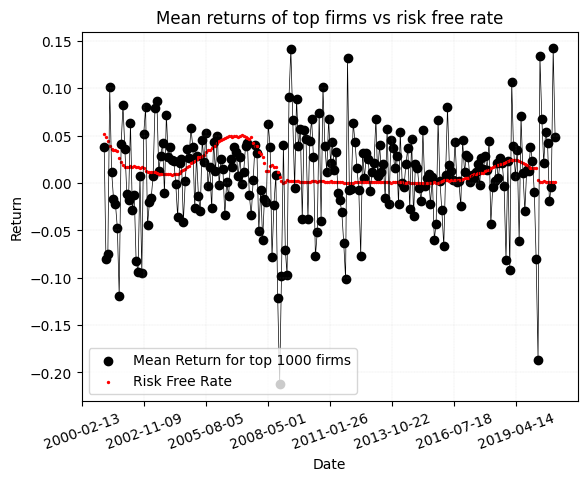

In [ ]:
df = pd.DataFrame({'index': mean_ret.index, 'values': mean_ret.values})
df1 = pd.DataFrame({'index': mean_ret.index, 'values': rf})

plt.plot(df['index'], df['values'],  linestyle='-', marker='', color='black', linewidth=0.5)
plt.scatter(df['index'], df['values'], label='Mean Return for top 1000 firms', color='black')


plt.scatter(df['index'],df1['values'], label='Risk Free Rate', color = 'red', s=2)


plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xticks(rotation=20)
plt.title('Mean returns of top firms vs risk free rate')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()

plt.grid(True, linestyle=':', linewidth=0.2)
plt.savefig('plot.svg', format='svg')


plt.show()

In [ ]:
rolling_window_size = 12
def mad_calculation(data):
    return np.abs(data - data.mean()).mean()

mad_result = merged_top_mod['RET'].rolling(window=rolling_window_size).apply(mad_calculation, raw=True)

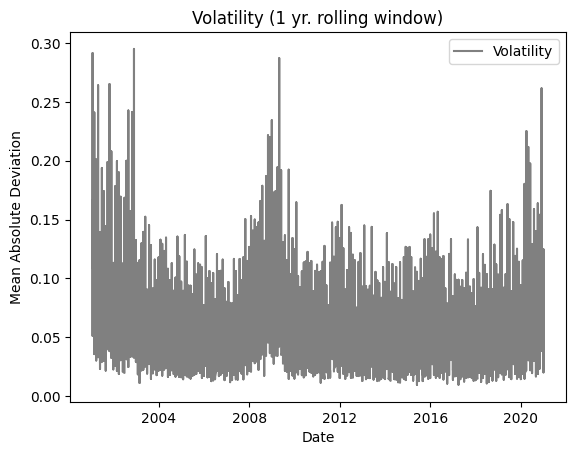

In [ ]:
mad_result = merged_top_mod['RET'].rolling(window=rolling_window_size).apply(mad_calculation, raw=True)
plt.plot(merged_top_mod['DATE'], mad_result, label="Volatility", color='grey')
plt.xlabel('Date')
plt.ylabel('Mean Absolute Deviation')
plt.title('Volatility (1 yr. rolling window)')
plt.legend()

# Save the plot as an SVG file
plt.savefig('mad_plot.svg')

# Show the plot
plt.show()

In [ ]:
#sector diagram
#print(merged_top_mod.head())

result = merged_top_mod.groupby('permno').apply(lambda group: group.filter(like='sic_').eq(1).idxmax(axis=1))
result_df = result.reset_index(level=0)
result_df.columns = ['permno', 'sic']
result_df = result_df.drop_duplicates(subset='permno', keep='first')

# Print or use the result DataFrame as needed
print(result_df)

#result.reset_index(drop=True)


#result.columns = ['id', 'sic_associated']


#print(result)
#print(len(result))

        permno     sic
232087       0   sic_1
234022       1   sic_1
209067       2  sic_82
2004         3  sic_63
144055       4  sic_35
...        ...     ...
213368    3357  sic_60
147026    3358  sic_28
224075    3359   sic_1
212003    3360   sic_1
218011    3361  sic_73

[3362 rows x 2 columns]


 **Quantile Analysis**





In [ ]:
returns_data = merged_top_mod['RET']
quant_val = 1/8*(np.arange(1,8))
quantiles = returns_data.quantile(quant_val)
for i in quant_val:
  if i==1/8:
    Qi_interval = (float('-inf'), quantiles[i])
  elif i ==8/8:
    Qi_interval = ( quantiles[i], float('inf') )
  else:
    Qi_interval = (quantiles[i-1/8], quantiles[i])
  print(Qi_interval)


(-inf, -0.083271625)
(-0.083271625, -0.0390485)
(-0.0390485, -0.011415375)
(-0.011415375, 0.0099945)
(0.0099945, 0.031626375)
(0.031626375, 0.05726025)
(0.05726025, 0.09729550000000001)


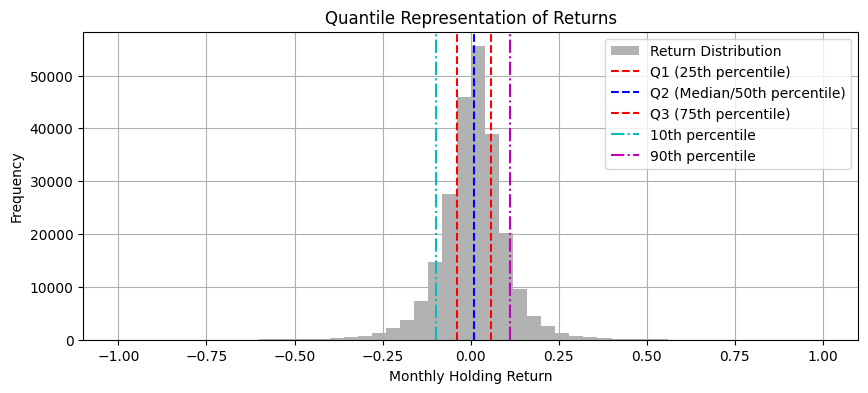

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = returns_data.tolist()
# Assuming 'data' is the correct variable name
q1 = np.percentile(data, 25)
q2 = np.percentile(data, 50)
q3 = np.percentile(data, 75)
p10 = np.percentile(data, 10)
p90 = np.percentile(data, 90)

plt.figure(figsize=(10, 4))
plt.hist(data, bins=50, alpha=0.6, color='grey', label="Return Distribution", range=[-1, 1])
plt.axvline(x=q1, color='r', linestyle='--', label="Q1 (25th percentile)")
plt.axvline(x=q2, color='b', linestyle='--', label="Q2 (Median/50th percentile)")
plt.axvline(x=q3, color='r', linestyle='--', label="Q3 (75th percentile)")
plt.axvline(x=p10, color='c', linestyle='-.', label="10th percentile")
plt.axvline(x=p90, color='m', linestyle='-.', label="90th percentile")

plt.title("Quantile Representation of Returns")
plt.xlabel("Monthly Holding Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('quantile_representation.png', format='png')
plt.show()


**Industries Represented**

In [ ]:
industry_mapping = {
    range(1,9): 'Agriculture, forestry and fishing',
    range(10,14): 'Mining',
    range(15,19): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation and public utilities',
    range(50, 52): 'Wholesale trade',
    range(52, 60): 'Retail trade',
    range(60, 68): 'Finance, insurance and real estate',
    range(70, 90): 'Services',
    range(91, 100): 'Public administration'
}

<ipython-input-165-3720d48fe442>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_ind = proportions_df.groupby('industry_group').sum()


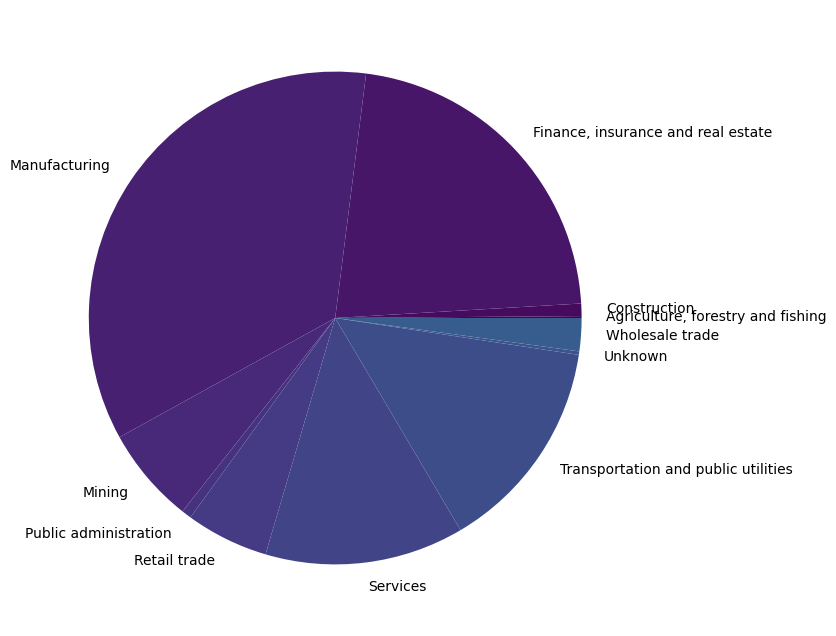

In [ ]:
proportions_df = pd.DataFrame(list(proportions.items()), columns=['sic', 'proportion'])

def map_sic_to_group(sic_value):
    for sic_range, industry_group in industry_mapping.items():
        if int(sic_value.split('_')[1]) in sic_range:
            return industry_group
    return 'Unknown'

proportions_df['industry_group'] = proportions_df['sic'].apply(map_sic_to_group)
final_ind = proportions_df.groupby('industry_group').sum()

plt.figure(figsize=(8, 8))
num_parts = 70

colors = plt.cm.viridis(np.linspace(0, 2, num_parts))

plt.pie(final_ind['proportion'], labels=final_ind.index, colors=colors)

# Save the plot as a PNG file
plt.savefig('pie_chart.png')

# Show the plot
plt.show()




Those selected permnos will be used for the tailor made performance evaluation metric


*   I first select the permnos that are always repeated int he dataset
*   There are 199 stocks available




In [ ]:
grouped_df = merged_top_mod.groupby('permno')['DATE'].agg(list).reset_index()
selected_permnos = []
for index, row in grouped_df.iterrows():
    if row['DATE'] == unique_dates_df['unique_dates'].tolist():
        selected_permnos.append(row['permno'])

In [ ]:
print("Number of available stocks for building a dynamic strategy " ,len(selected_permnos))
#print(selected_permnos)
#print(grouped_df.iloc[44,:].tolist())   # checking if code worked

Number of available stocks for building a dynamic strategy  199


Statistical Modeling

Linear modeling on top panel

In [ ]:
#my metric
#pick stocks that are present at all times in testing, training and validation
#I will see in the merged_data_

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

In [ ]:
def R_oos(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    actual_mean = np.mean(actual)
    return 1 - (np.dot((actual-predicted),(actual-predicted)))/np.dot((actual-actual_mean),(actual-actual_mean))

In [ ]:
def evaluate(actual, predicted, insample):
    if insample == True:
        print('*'*15+'In-Sample Metrics'+'*'*15)
        print(f'The in-sample R2 is {r2_score(actual,predicted)*100:.7f}%')
        print(f'The in-sample MSE is {mean_squared_error(actual,predicted):.7f}')
    else:
        print('*'*15+'Out-of-Sample Metrics'+'*'*15)
        print(f'The out-of-sample R2 is {R_oos(actual,predicted)*100:.7f}%')
        print(f'The out-of-sample MSE is {mean_squared_error(actual,predicted):.7f}')

Naive OLS on the feature set

In [ ]:
from sklearn.linear_model import LinearRegression

OLS = LinearRegression().fit(X_trn,y_trn)
evaluate(y_trn, OLS.predict(X_trn), insample=True)
evaluate(y_tst, OLS.predict(X_tst),insample = False)

***************In-Sample Metrics***************
The in-sample R2 is 19.9166341%
The in-sample MSE is 0.0092240
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -14276.6131380%
The out-of-sample MSE is 1.2355870


Low dimensional Linear Model using OLS
I use well documented factors.Typically considered robust
ols_3

In [ ]:
from sklearn.linear_model import LinearRegression

# OLS with preselected size, bm, and momentum covariates
features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)
evaluate(y_trn, OLS_3.predict(X_trn[features_3]), insample=True)
evaluate(y_tst, OLS_3.predict(X_tst[features_3]),insample=False)

***************In-Sample Metrics***************
The in-sample R2 is 0.4359409%
The in-sample MSE is 0.0114678
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -1.1550289%
The out-of-sample MSE is 0.0086937


Naive linear model, estimated with huber loss function

In [ ]:
from sklearn.linear_model import HuberRegressor

epsilon = np.max(((y_trn-OLS.predict(X_trn)).quantile(.999),1))
OLS_H = HuberRegressor(epsilon=epsilon).fit(X_trn,y_trn)
evaluate(y_trn, OLS_H.predict(X_trn), insample=True)
evaluate(y_tst, OLS_H.predict(X_tst),insample= False)

***************In-Sample Metrics***************
The in-sample R2 is 13.7138623%
The in-sample MSE is 0.0099385
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -36.9084712%
The out-of-sample MSE is 0.0117665


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


linear model with selected features estimated using huber loss

In [ ]:
from sklearn.linear_model import HuberRegressor

# OLS by Huber robust objective function
# with preselected size, bm, and momentum covariates
epsilon = np.max(((y_trn-OLS_3.predict(X_trn[features_3])).quantile(.999),1))
features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']
OLS_H_3 = HuberRegressor(epsilon=epsilon).fit(X_trn[features_3],y_trn)

evaluate(y_trn, OLS_H_3.predict(X_trn[features_3]), insample=True)
evaluate(y_tst, OLS_H_3.predict(X_tst[features_3]),insample=False)

***************In-Sample Metrics***************
The in-sample R2 is 0.2131522%
The in-sample MSE is 0.0114935
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -0.4378110%
The out-of-sample MSE is 0.0086321


In [ ]:
from sklearn.linear_model import LinearRegression
# OLS with preselected size, bm, and momentum covariates
features_3 = ['mvel1','bm','mom12m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)

evaluate(y_tst, OLS_3.predict(X_tst[features_3]),insample=False)

***************Out-of-Sample Metrics***************
The out-of-sample R2 is -0.3647499%
The out-of-sample MSE is 0.0086258


In [ ]:
# OLS with preselected size, bm, and momentum covariates
features_7 = ['mvel1','bm','mom12m','acc','roaq','agr','egr']
OLS_7 = LinearRegression().fit(X_trn[features_7],y_trn)

evaluate(y_tst, OLS_7.predict(X_tst[features_7]),insample=False)

***************Out-of-Sample Metrics***************
The out-of-sample R2 is -1.4084132%
The out-of-sample MSE is 0.0087155


In [ ]:
 # OLS with preselected size, bm, and momentum covariates
features_15 = ['mvel1','bm','mom12m','acc','roaq','agr','egr','dy','beta','retvol','turn','lev','sp','mom36m']
OLS_15 = LinearRegression().fit(X_trn[features_15],y_trn)

evaluate(y_tst, OLS_15.predict(X_tst[features_15]),insample=False)


***************Out-of-Sample Metrics***************
The out-of-sample R2 is -3.7306822%
The out-of-sample MSE is 0.0089151


In [ ]:
def R_oos_other(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted).flatten()
    predicted = np.where(predicted<0,0,predicted)
    return 1 - (np.dot((actual-predicted),(actual-predicted)))/(np.dot(actual,actual))

In [ ]:
def eval_other(actual, predicted, insample):
    if insample == True:
        print('*'*15+'In-Sample Metrics'+'*'*15)
        print(f'The in-sample R2 is {r2_score(actual,predicted)*100:.2f}%')
        print(f'The in-sample MSE is {mean_squared_error(actual,predicted):.3f}')
    else:
        print('*'*15+'Out-of-Sample Metrics'+'*'*15)
        print(f'The out-of-sample R2 is {R_oos_other(actual,predicted)*100:.2f}%')
        print(f'The out-of-sample MSE is {mean_squared_error(actual,predicted):.7f}')

In [ ]:
from sklearn.linear_model import LinearRegression
# OLS with preselected size, bm, and momentum covariates
features_3 = ['mvel1','bm','mom12m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)

eval_other(y_tst, OLS_3.predict(X_tst[features_3]),insample=False)

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.68%
The out-of-sample MSE is 0.0086258


In [ ]:
# OLS with preselected size, bm, and momentum covariates
features_7 = ['mvel1','bm','mom12m','acc','roaq','agr','egr']
OLS_7 = LinearRegression().fit(X_trn[features_7],y_trn)

eval_other(y_tst, OLS_7.predict(X_tst[features_7]),insample=False)

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.41%
The out-of-sample MSE is 0.0087155


In [ ]:
 # OLS with preselected size, bm, and momentum covariates
features_15 = ['mvel1','bm','mom12m','acc','roaq','agr','egr','dy','beta','retvol','turn','lev','sp','mom36m']
OLS_15 = LinearRegression().fit(X_trn[features_15],y_trn)

eval_other(y_tst, OLS_15.predict(X_tst[features_15]),insample=False)


***************Out-of-Sample Metrics***************
The out-of-sample R2 is -0.52%
The out-of-sample MSE is 0.0089151


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
selected_col = merged_top_mod['RED']
X = selected_col.values
ica = FastICA(n_components=2)
ica_result = ica.fit_transform(X)

# Calculate limits for both subplots
data_limits = np.vstack([X.min(axis=0), X.max(axis=0)])
ica_limits = np.vstack([ica_result.min(axis=0), ica_result.max(axis=0)])
global_limits = np.vstack([data_limits, ica_limits])
global_min = global_limits.min(axis=0)
global_max = global_limits.max(axis=0)

# Plot the original data and the independent components
plt.figure(figsize=(10, 5))

# Plot the original data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Original Data')
plt.xlim(global_min[0], global_max[0])
plt.ylim(global_min[1], global_max[1])

# Plot the independent components with the same scale
plt.subplot(1, 2, 2)
plt.scatter(ica_result[:, 0], ica_result[:, 1])
plt.title('Independent Components')
plt.xlim(global_min[0], global_max[0])
plt.ylim(global_min[1], global_max[1])

# Plot lines defining the Independent Components
x_line = np.linspace(global_min[0], global_max[0], 100)

# Line for the first independent component
coef_1 = ica.components_[0]
y_line_1 = -(coef_1[0] / coef_1[1]) * x_line
plt.plot(x_line, y_line_1, color='red', label='IC 1')

# Line for the second independent component
coef_2 = ica.components_[1]
y_line_2 = -(coef_2[0] / coef_2[1]) * x_line
plt.plot(x_line, y_line_2, color='blue', label='IC 2')

plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.274448 -0.024685 -0.320843 ...  0.028058  0.039006  0.114574].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

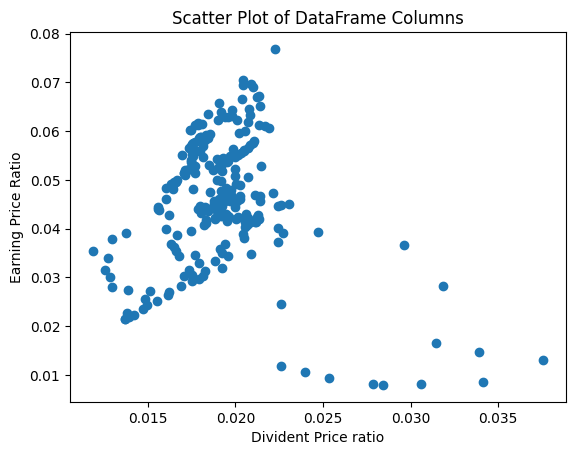

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'col1' and 'col2' with the actual column names you have in your DataFrame
plt.scatter(selected_col['dp'], selected_col['ep'])
plt.xlabel('Divident Price ratio')
plt.ylabel('Earning Price Ratio')
plt.title('ICA vs PCA')
plt.show()
